!conda info

## Data Processing ##

In [1]:
# Setup pandas display attributes
import pandas as pd

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 20)

In [2]:
# Load data
df = pd.read_csv('../data/mental_health_sentiment.csv', index_col=0)
# Rename text and label columns to be generic
df.rename(columns={"statement": "text", "status": "label"}, inplace=True)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    52681 non-null  object
 1   label   53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


,text,label
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless heart. All out of tune",Anxiety
2,"All wrong, back off dear, forward doubt. Stay in a restless and restless place",Anxiety
3,I've shifted my focus to something else but I'm still worried,Anxiety
4,"I'm restless and restless, it's been a month now, boy. What do you mean?",Anxiety


In [3]:
# Statistical features
df["label"].value_counts()

label
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [4]:
# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", '', text)              # remove punctuation and numbers
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/neiderer.c/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/neiderer.c/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Encode Sentiment Labels
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['label_encoded'] = encoder.fit_transform(df['label'])

# Print encoding map for reference
label_map = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(label_map)

{'Anxiety': np.int64(0), 'Bipolar': np.int64(1), 'Depression': np.int64(2), 'Normal': np.int64(3), 'Personality disorder': np.int64(4), 'Stress': np.int64(5), 'Suicidal': np.int64(6)}


In [6]:
# Train-Test Split
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['label_encoded']

# 80-20 stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
# Text Vectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

2025-07-01 11:31:40.456505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751383900.478130 3361306 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751383900.484880 3361306 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751383900.501640 3361306 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751383900.501653 3361306 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751383900.501656 3361306 computation_placer.cc:177] computation placer alr

In [8]:
# Filter out empty sequences
non_empty_train = X_train_pad.sum(axis=1) > 0
X_train_pad = X_train_pad[non_empty_train]
y_train = y_train[non_empty_train]

non_empty_test = X_test_pad.sum(axis=1) > 0
X_test_pad = X_test_pad[non_empty_test]
y_test = y_test[non_empty_test]

## TF-IDF + Logistic Regression ##

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       778
           1       0.84      0.69      0.76       575
           2       0.71      0.74      0.72      3081
           3       0.83      0.95      0.89      3250
           4       0.64      0.52      0.58       240
           5       0.67      0.42      0.52       534
           6       0.69      0.63      0.66      2131

    accuracy                           0.76     10589
   macro avg       0.74      0.67      0.70     10589
weighted avg       0.75      0.76      0.75     10589



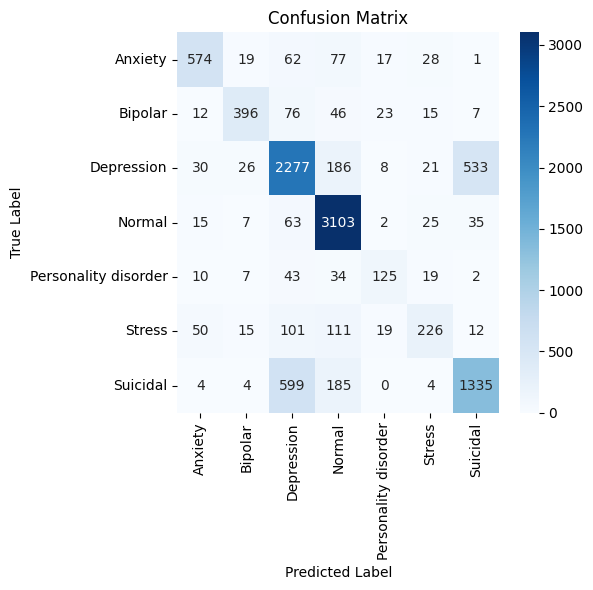

In [10]:
non_empty_text = X_train.str.strip().astype(bool)
X_train = X_train[non_empty_text]
y_train = y_train[non_empty_text]

non_empty_text_test = X_test.str.strip().astype(bool)
X_test = X_test[non_empty_text_test]
y_test = y_test[non_empty_text_test]

# TF-IDF feature extraction
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression
logreg_model = LogisticRegression(max_iter=1000)
# %timeit logreg_model.fit(X_train_tfidf, y_train)
logreg_model.fit(X_train_tfidf, y_train)

# Predict and evaluate
logreg_preds = logreg_model.predict(X_test_tfidf)
print("Logistic Regression Report:")
print(classification_report(y_test, logreg_preds))

# Confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, logreg_preds), annot=True, xticklabels=encoder.classes_, yticklabels=encoder.classes_, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("../figures/lr_confusion_matrix.png")
plt.show()

## TF-IDF + SVM ##

SVM Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       778
           1       0.82      0.74      0.78       575
           2       0.70      0.71      0.70      3081
           3       0.85      0.94      0.90      3250
           4       0.65      0.64      0.64       240
           5       0.64      0.46      0.54       534
           6       0.65      0.62      0.64      2131

    accuracy                           0.75     10589
   macro avg       0.73      0.70      0.71     10589
weighted avg       0.75      0.75      0.75     10589



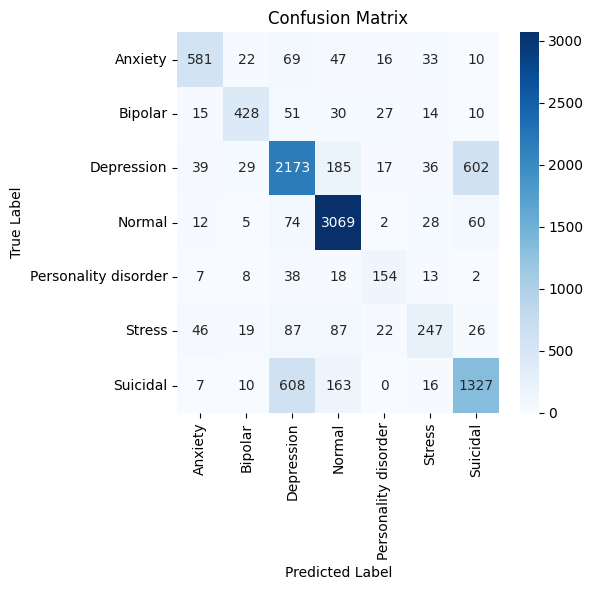

In [11]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train SVM using the same TF-IDF features
svm_model = LinearSVC()
# %timeit svm_model.fit(X_train_tfidf, y_train)
svm_model.fit(X_train_tfidf, y_train)

# Predict and evaluate
svm_preds = svm_model.predict(X_test_tfidf)
print("SVM Report:")
print(classification_report(y_test, svm_preds))

# Confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, svm_preds), annot=True, xticklabels=encoder.classes_, yticklabels=encoder.classes_, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("../figures/svm_confusion_matrix.png")
plt.show()


## Transformer-Based (BERT fine-tuning) ##

In [12]:
# !pip install -U numpy datasets
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import evaluate
import numpy as np

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)


# Convert train/test to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_train.tolist(), 'label': y_train.tolist()}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_test.tolist(), 'label': y_test.tolist()}))

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Load BERT model
num_labels = len(set(y_train))
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

# Define training args
training_args = TrainingArguments(
    output_dir="./bert_output",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    logging_dir="./logs",
    save_strategy="epoch",
    report_to="none"
)

# Evaluation metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1.compute(predictions=predictions, references=labels, average='macro')["f1"]
    }

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train and evaluate
trainer.train()
results = trainer.evaluate()
print("BERT Evaluation:", results)

# Confusion matrix
bert_preds = np.argmax(trainer.predict(test_dataset).predictions, axis=1)
sns.heatmap(confusion_matrix(y_test, bert_preds), annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - BERT")
plt.show()

Defaulting to user installation because normal site-packages is not writeable


ImportError: /home/neiderer.c/.local/lib/python3.9/site-packages/torch/lib/../../nvidia/cusparse/lib/libcusparse.so.12: undefined symbol: __nvJitLinkGetErrorLog_12_6, version libnvJitLink.so.12

In [ ]:
print("BERT Classification Report:\n")
print(classification_report(y_test, bert_preds, digits=4))